In [12]:
# Import packages 
import os, glob, sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import cv2

from tqdm.auto import tqdm
from scipy import ndimage
from PIL import Image

# append path
sys.path.append('../')
sys.path.append('../utils/')

# custom
from BuildUNet import BuildUNet
from GetLowestGPU import GetLowestGPU
from TileGenerator import TileGenerator



# Import Best Model Weights

In [2]:
# Load model
# instantiate model
model_kwargs = {
    'input_features': 3,
    'output_features': 4,
    'layers': [32, 64, 128],
    'n_convs': 3,
    'dropout_rate': 0.1,
    'use_batchnorm': True,
    'hidden_activation': torch.nn.SELU(),
    'output_activation': torch.nn.Softmax(dim=1),
}

unet = BuildUNet(**model_kwargs)
opt = torch.optim.AdamW(unet.parameters(), lr=1e-3)
loss_function = torch.nn.BCELoss()


In [3]:
# load model weights
# weights = torch.load("../weights/pennycress_multiclass_best_val_model.pt", map_location=torch.device('cpu'))
checkpoint = torch.load("../checkpoints/checkpoint_56000.pt", map_location=torch.device('cpu'))


#extract weights from checkpoint
weights = checkpoint['model']

# trained model has been loaded
unet.load_state_dict(weights)
unet.eval()#inference mode (no dropout, batch norm uses running mean, etc.)

BuildUNet(
  (hidden_activation): SELU()
  (output_activation): Softmax(dim=1)
  (input_conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SELU()
    (3): Dropout2d(p=0.1, inplace=False)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): SELU()
    (7): Dropout2d(p=0.1, inplace=False)
    (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): SELU()
    (11): Dropout2d(p=0.1, inplace=False)
  )
  (encoder_ops): ModuleList(
    (0): Sequential(
      (0): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_

# Load Images

In [4]:
# load in images

# options
image_path = "../pennycress_pods/images/"
mask_path = "../pennycress_pods/masks/"
save_path = "../pennycress_pods/predictions/"

# load image data
image_names = glob.glob(mask_path + "*.png")
image_names = [os.path.basename(x) for x in image_names]

# Create Predicted Segmentation Masks for Images

  0%|          | 0/15229 [00:00<?, ?it/s]

  0%|          | 0/8989 [00:00<?, ?it/s]

  0%|          | 0/15453 [00:00<?, ?it/s]

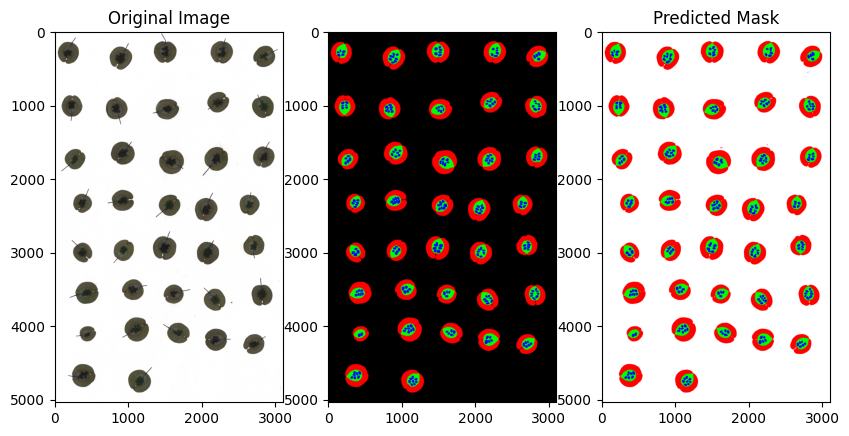

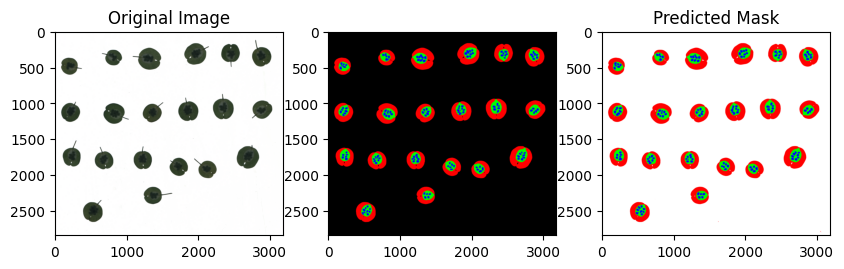

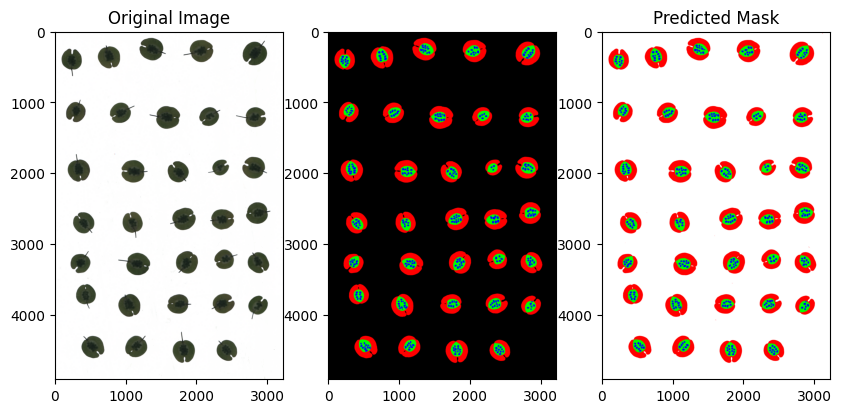

In [7]:
# create list to store predicted segmentations so that we can count seeds later
pred_images = []

# loop over images
for image_name in image_names:
    ## PREPROCESSING
    # load in image and convert to a numpy array
    image = Image.open(image_path + image_name)
    image = np.array(image) / 255.0

    mask = Image.open(mask_path + image_name)

    # pad first 2 dimensions, (H, W) by 32 px
    image = np.pad(image,
                pad_width= ((32, 32), (32, 32), (0, 0)),
                mode='edge')

    # ensure each image is divisible by 128 by adding extra padding

    rpad = 128 - image.shape[0] % 128
    cpad = 128 - image.shape[1] % 128

    # do we really need this? or can we optimize?
    image = np.pad(image,
                pad_width=((0, rpad), (0, cpad), (0, 0)),
                mode='edge')

    # initialize global prb. map with same spatial (H, W) dimensions as image and channel for each class
    global_prb_map = np.zeros((image.shape[0], image.shape[1], 4))

    ## BOOKKEEPING / PREDICTION

    # Double for loop over rows and columns with step size of 32 used for tile generation
    rows = range(0, image.shape[0]-(3*32), 32)
    cols = range(0, image.shape[1]-(3*32), 32)
    with tqdm(total=len(rows)*len(cols)) as pbar:
        for row in range(0, image.shape[0]-(3*32), 32): #don't index completely to the edge - otherwise, we will be indexing into a space that doesn't exist in the image
            for col in range(0, image.shape[1]-(3*32), 32):

                # select image tile
                tile = image[row:row+128, col:col+128]

                # make prediction and store the *center context* in global prb. map
                unet_input = torch.tensor(tile, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)

                # shuffle to be rows-cols-channels order and only take the center 64x64 square
                prediction = unet(unet_input)[0].permute(1, 2, 0)[32:-32, 32:-32, :] 

                # add predicted probabilities to prb map at index
                global_prb_map[row+32:row+96, col+32:col+96, :] += prediction.detach().numpy()
                pbar.update(1)

    # now that we have full prb. map, remove the padding 
    global_prb_map = global_prb_map[32:-(32+rpad), 32:-(32+cpad), :]
    image = image[32:-(32+rpad), 32:-(32+cpad), :]

    # and normalize prbs. s.t they sum to one
    global_prb_map = global_prb_map / global_prb_map.sum(axis=-1, keepdims=True)

    # convert predicted probabilities to predicted classes and retain four channels
    argmaxes = np.argmax(global_prb_map, axis=2)
    preds = np.zeros(global_prb_map.shape)
    for i in range(4):
        preds[:, :, i] = (argmaxes == i)

    # remove bg channel
    pred_image = preds[:, :, 1:]
    pred_image[pred_image.sum(axis=2) == 0] = 1

    # # perform morphological opening to remove small noise/artifacts
    # kernel = np.ones((5, 5), np.uint8)
    
    # gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    # plot the image and prediction together
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    ax[0].imshow(image)
    ax[0].set_title("Original Image")

    ax[1].imshow(mask)
    ax[2].set_title("Ground Truth Mask")

    ax[2].imshow(pred_image)
    ax[2].set_title("Predicted Mask")
    plt.show

    # append to pred images list for counting
    pred_images.append(pred_image)

    # save the predicted mask
    pred_image = Image.fromarray((pred_image * 255).astype(np.uint8))
    pred_image.save(save_path + "pred" + image_name)

# Seed Counting

seed count: 20


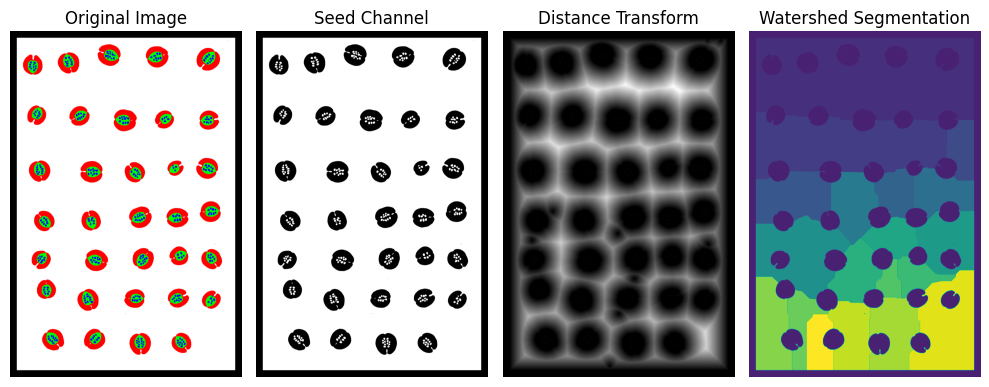

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('float64'), dtype('<U1')) -> None

In [13]:
# Seed Counting

for pred_image_name in pred_images:

        # revert white background to black
        pred_image[pred_image.sum(axis=2) == 3] = 0

        # pad image so that we can draw bounding box around it
        pred_image = np.pad(pred_image, ((100, 100), (100, 100), (0, 0)), mode='constant')

        # extract bool mask for object detection
        bool_mask = np.array(pred_image).sum(axis=2) > .5 # convert to boolean mask

        # label each object in the image and draw bounding box around it
        labels = ndimage.label(bool_mask)[0]
        bboxes = ndimage.find_objects(labels)

        # add padding to bounding boxes
        x_pad, y_pad = 100, 100
        for i in range(len(bboxes)):
                x, y = bboxes[i]
                bboxes[i] = slice(x.start-x_pad, x.stop+x_pad), slice(y.start-y_pad, y.stop+y_pad)


        # create list to store seed counts
        seed_counts = []

        # loop through split images
        for i, bbox in enumerate(bboxes):
                y, x = bbox
                split_image = pred_image[y, x, :]

                # extract only the blue channel (seeds) from the image
                seed_channel = split_image[:, :, 2].astype(np.int64)

                # change image type and make 3-channel mask
                seed_channel = seed_channel.astype(np.uint8)
                seed_channel_rgb = cv2.cvtColor(seed_channel, cv2.COLOR_GRAY2RGB) * 255

                # create kernel and perform morphological operation

                # noise removal w/ morphological opening (erosion then dilation)
                kernel = np.ones((1,1),np.uint8)
                opening = cv2.morphologyEx(seed_channel,
                                        cv2.MORPH_OPEN,
                                        kernel, 
                                        iterations = 2) 

                # sure background area (dilate the output of our opening)
                sure_bg = cv2.dilate(opening,kernel,iterations=3)

                # Finding sure foreground area
                dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
                ret, sure_fg = cv2.threshold(dist_transform,0.6*dist_transform.max(),255,0)

                # Finding unknown region
                sure_fg = np.uint8(sure_fg)
                unknown = cv2.subtract(sure_bg,sure_fg)

                # Marker labelling
                ret, markers = cv2.connectedComponents(sure_fg)

                # Add one to all labels so that sure background is not 0, but 1
                markers = markers+1

                # Now, mark the region of unknown with zero
                markers[unknown==255] = 0

                markers = cv2.watershed(seed_channel_rgb,markers)
                seed_channel_rgb[markers == -1] = [255,0,0]

                seed_count = len(np.unique(markers)) - 2
                print("seed count:", seed_count)

                # visualize!
                fig, ax = plt.subplots(1, 4, figsize=(10, 5))
                ax[0].imshow(split_image)
                ax[0].set_title("Original Image")

                ax[1].imshow(seed_channel, cmap='gray')
                ax[1].set_title("Seed Channel")

                ax[2].imshow(dist_transform, cmap='gray')
                ax[2].set_title("Distance Transform")

                ax[3].imshow(markers)
                ax[3].set_title("Watershed Segmentation")

                for a in ax:
                        a.set_axis_off()

                fig.tight_layout()
                plt.show()



                # save split predicted image
                save_name = pred_image_name[:-4] + "_" + str(i) + ".png"
                split_image = Image.fromarray((split_image * 255).astype(np.uint8))
                split_image.save(image_save_path + save_name)

                # save seed count
                seed_counts.append((save_name, seed_count))

        # save seed counts to csv
        seed_counts = pd.DataFrame(seed_counts, columns=["image_name", "seed_count"])
        seed_counts.to_csv(seed_save_path + "seed_counts.csv", index=False)

